In [1]:
%matplotlib inline

In [2]:
import time
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Rectangle
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from skimage.filters import gaussian

import math

from datetime import date
from collections import OrderedDict
from glob import glob
from scipy import ndimage
from skimage import img_as_float, io
import imageio
import json

## Introduction

In our mFISH image analysis pipeline, we are hoping to implement nuclei segmentation to aid in the detection of signal by separation of target cells from the background. Our goal is to increase accuracy of readout detection, as well as to expedite the process by removing unnecessary regions from the images to be processed.


## Objectives
This code is used to take a large image and then split it into individual components which will be processed separately (stardist), and then stitch them back together afterwards to form a processed version of the original. Ideally, the raw image file, the grid overlaid image, as well as the post-processed image will all be retained.

The steps to achieve this are as follows:

1. Input image


2. Image slicer
    - overlay a grid, with overlapping cells
    - create subimages based on cell coordinates
    - save subimages to a created folder on disk
    - save coordinates of subimages that will be serialized into a json file in the same folder
    
    
3. Process subimage tiles
    - stardist segmentation


4. Reconstruct processed version of original image
    - separate file from raw original


5. Output should be the original image, the subimage tiles, and the post-processed construct

Object segmentation through stardist is computationally expensive and has an upper limit on image file size, so by breaking the original into more manageable subimages, this should mitigate the issue.

## Code mechanics

We begin by pulling information about the dimensions of the image using `.shape`:

```
sample.shape
(21504, 19558)
```
Then set up our parameters:

```
tile_step = 2000
tile_size = 2048

```

- `tile_step` is the increment along the x and y axis which will determine the size of the overall grid

- `tile_size` is the size of individual grid cells
Note that the `tile_size` is larger than `tile_step` (2048 vs. 2000), thus causing overlaps from tile to tile. This is intentional to accomodate for objects that are split along gridlines. The overlaps serve as a buffer zone so that split objects can be stitched together later.

We calculate how many tiles will fit across the length and width of the image:

```
length = math.ceil(sample.shape[0]/tile_step)
width = math.ceil(sample.shape[1]/tile_step)
print(length)
print(width)

11
10
```
---

In [3]:
#local machine
sample = img_as_float(io.imread('C:/Users/jv92c/Documents/mFISH/sample_data/DAPI_empty_Overview_cropped.tif'))

In [ ]:
#work machine
sample = img_as_float(io.imread('C:/Users/john.villanueva/OneDrive/Documents/sample_data/DAPI_Overview.tif'))

In [4]:
sample.dtype

dtype('float64')

In [5]:
today = date.today()
sample.shape

(9699, 5893)

In [ ]:
#local machine
if not os.path.exists('C:/Users/jv92c/Documents/mFISH/sample_data/DAPI_Overview_subimg'):
    os.makedirs('C:/Users/jv92c/Documents/mFISH/sample_data/DAPI_Overview_subimg')

In [ ]:
#work machine
if not os.path.exists('C:/Users/john.villanueva/OneDrive/Documents/sample_data/DAPI_Overview_subimg'):
    os.makedirs('C:/Users/john.villanueva/OneDrive/Documents/sample_data/DAPI_Overview_subimg')


### Setting up the loop

```
tile_range_r = np.arange(0, sample.shape[0]+tile_size, tile_step)
tile_range_c = np.arange(0, sample.shape[1]+tile_size, tile_step)
```

- `tile_range` consists of values from 0 to the ceiling of `shape` values + `tile_size`, in increments of `tile_step`, effectively a list of row/column length. The addition of one increment of `tile_size` to the `shape` value ensures that the range fully covers the size of the image being processed. The overhang is negligible as it will not affect the creation of a grid.

Using our current values, our outputs are:
```
tile_range_r
[0, 2000, 4000, 8000, 10000, 12000, 14000, 16000, 18000, 20000, 22000]

tile_range_c
[0, 2000, 4000, 8000, 10000, 12000, 14000, 16000, 18000, 20000]
```
---

In [7]:
#slice intervals
tile_step = 2000

#size of the 2D slice
#also determines the overlap between FOVs for use in stitching of edge objects
tile_size = 2100

In [8]:
length = math.ceil(sample.shape[0]/tile_step)
width = math.ceil(sample.shape[1]/tile_step)

print('length = '+ str(length))
print('width = '+ str(width))

length = 5
width = 3


### Integrating meshgrid

```
xs, ys = np.meshgrid(tile_range_r, tile_range_c, indexing='ij')
```

`meshgrid` is a method where a cartesian grid is generated given certain parameters. In this case, our grid is composed of coordinates given by `tile_range_r` and `tile_range_c`. Indexing has been changed from cartesian to matrix indexing. This will set up the overlay that we need.

---

In [9]:
#range in the x-direction determined by width of image; row length
tile_range_r = np.arange(0, sample.shape[0], tile_step)

#range in the y-direction determined by height; column height
tile_range_c = np.arange(0, sample.shape[1], tile_step)

rs, cs = np.meshgrid(tile_range_r, tile_range_c, indexing='ij')

In [10]:
#local machine
output_dir = 'C:/Users/jv92c/Documents/mFISH/sample_data/DAPI_Overview_subimg'

In [ ]:
#work machine
output_dir = 'C:/Users/john.villanueva/OneDrive/Documents/sample_data/DAPI_Overview_subimg'

### Main `for` loop

```
for ii, tile in enumerate(rs.ravel()):
    
    r_min = rs.ravel()[ii]
    r_max = np.min([rs.ravel()[ii]+tile_size, sample.shape[0]])
    
    c_min = cs.ravel()[ii]
    c_max = np.min([cs.ravel()[ii]+tile_size, sample.shape[1]])
        
    sub_image = sample[r_min:r_max,c_min:c_max]
    img_coordinates.append([r_min, r_max, c_min, c_max])
```

we begin by defining variables to capture the edges of the subimage tiles. The `r_max` and `c_max` values are offset by 2048 pixels to introduce the overlap that takes into account edge objects, which will be stitched together post-processing. `sub_image` is defined as all values within the range of `r_min` to `r_max` and `c_min` to `c_max`. And the min/max values themselves are then added to an initialized list, which will keep track of each corner of each subimage tile generated. `ravel` converts the `rs` meshgrid into a 1D array, which can then be iterated through by using the `enumerate` function. In calculating `c_min` and `c_max` the `cs` meshgrid is also flattened by applying the `ravel` method.

---

```
    for i in range((length*width)):
        
        if ii == i:
            
            rect = Rectangle((c_min, r_min), c_max-c_min, r_max-r_min, linewidth=1, edgecolor='g', facecolor='none')
            ax.add_patch(rect)
            
            ax.text(c_min, r_min, str(r_min)+", "+str(c_min))
            
            plt.figure()
            plt.imshow(sub_image)
            
            img_pos['_DAPI_Overview_subimage_'+str(i).zfill(5)] = [int(j) for j in img_coordinates[i]]
```
the nested portion of the loop first calculates how many tiles can cover the raw image, the tile number is then matched to the index of the `ravel` array through a conditional. Once it has, a grid trace is applied to show how the raw image will be subdivided, and then the image tiles are displayed and stored to disk (still working on this part). Lastly, a filename is generated for each subimage, which becomes the keys to a dictionary whose values are the tile coordinates. This will later be serialized into a `json`.  

---

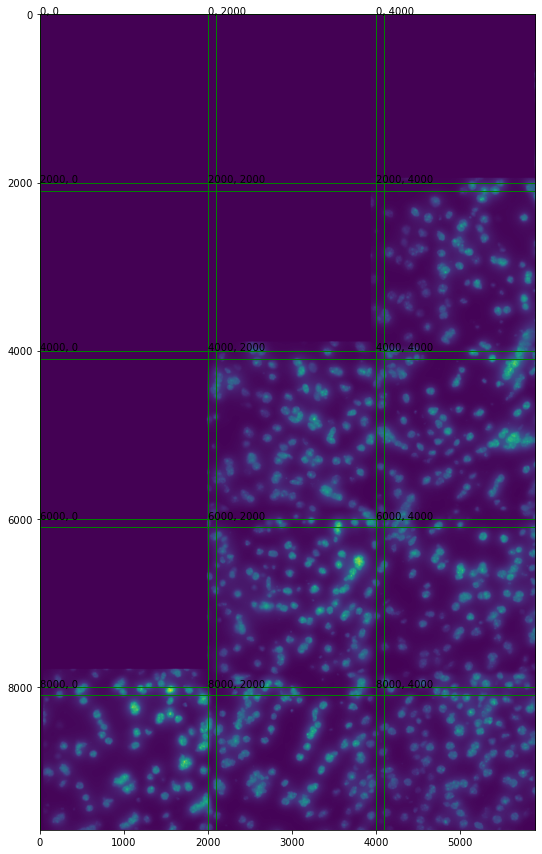

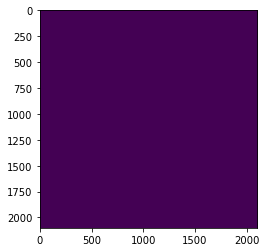

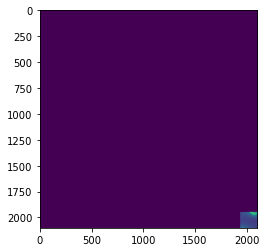

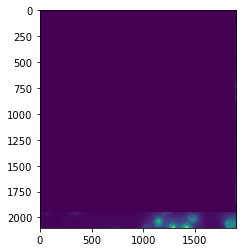

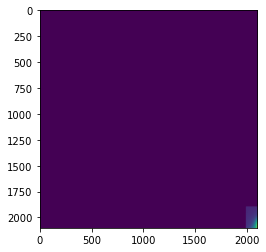

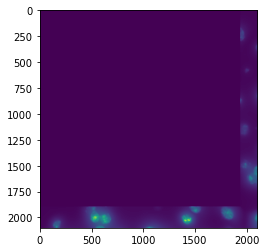

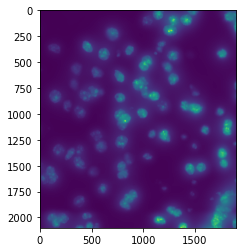

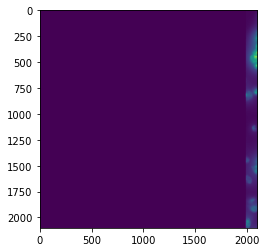

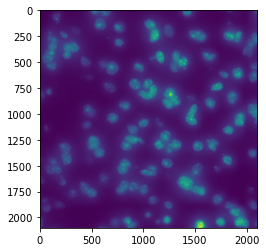

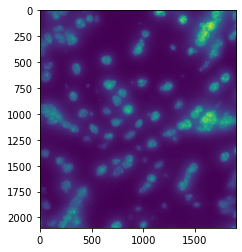

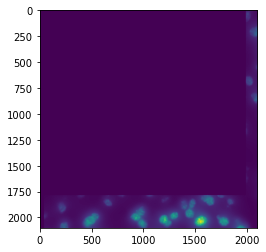

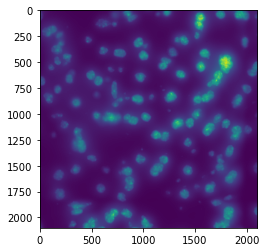

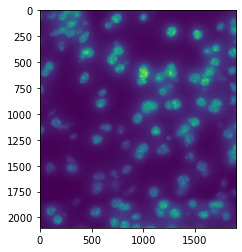

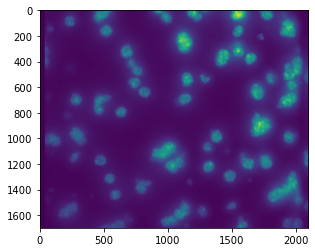

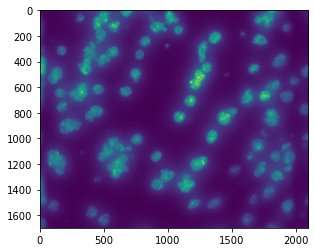

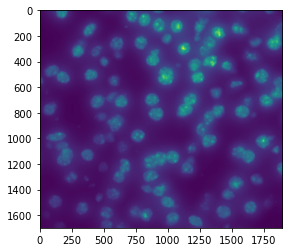

In [11]:
plt.figure(figsize= [15,15])
plt.imshow(sample)
ax = plt.gca()

img_coordinates = []
img_pos = OrderedDict()

for ii, tile in enumerate(rs.ravel()):
    
    #setting the coordinates
    r_min = rs.ravel()[ii]
    r_max = np.min([rs.ravel()[ii]+tile_size, sample.shape[0]])
    
    c_min = cs.ravel()[ii]
    c_max = np.min([cs.ravel()[ii]+tile_size, sample.shape[1]])
        
    sub_image = sample[r_min:r_max,c_min:c_max]
    img_coordinates.append([r_min, r_max, c_min, c_max])
    
    for i in range((length*width)):
        
        if ii == i:
            
            #grid overlay for sample image
            rect = Rectangle((c_min, r_min), c_max-c_min, r_max-r_min, linewidth=1, edgecolor='g', facecolor='none')
            ax.add_patch(rect)
            
            #upper-left corner coordinates of each tile
            ax.text(c_min, r_min, str(r_min)+", "+str(c_min))
            
            # figure to display subimage
            plt.figure()
            plt.imshow(sub_image)
            
            #saving subimages to disk
            imageio.imwrite('{}/DAPI_Overview_subimage_{}.tif'.format(output_dir, str(i).zfill(5)), sub_image)
            
            #creating a dictionary for export to json
            img_pos['DAPI_Overview_subimage_'+str(i).zfill(5)] = [int(j) for j in img_coordinates[i]]
            #add this string <today.strftime("%Y%m%d")+> in front of _DAPI_Overview_subimage if you want to have a timestamp as part of the file handle
            
            

#### Context manager

"w" is a variable, which is the output of the file that is being opened. This variable only exists within the context
of this code block

if the statement is done/fails, the file will still close.
```
# with open(<filename>, 'w') as w:
# json.dump(my_dictionary, w)
```

no need to set up classes, just proper serialization of the json file

In [12]:
#today.strftime("%Y%m%d") for the date
#+str(int(time.time())) for the timestamp

filename = 'DAPI_Overview_subimage_'

In [13]:
#use path to access directory of images
#assuming that they'll be in the same folder post-stardist

with open(filename, 'w') as file:    
    json.dump(img_pos, file)

In [14]:
with open(filename) as file:    
    coordinates = json.load(file, object_pairs_hook=OrderedDict)

#### Reconstructing the image

This segment reads `tif` files stored to disk. 
By using the coordinates stored in the previously generated `json` file, we change values of a zero `ndarray` to that of the subimage tile being read.

First is to read the raw data tiles

In [15]:
#creating a zero array to begin image reconstruction

boundary = []

for key in coordinates:
    boundary.append(coordinates[key])
    
canvas = np.zeros((boundary[-1][1], boundary[-1][3]))

In [16]:
#testing with the original data

for key in coordinates:
    
    '''
    within the zero ndarray, we overlay an image whose corners 
    will be set by the coordinates stored within the dictionary
    '''
    
    canvas[coordinates[key][0]:coordinates[key][1], coordinates[key][2]:coordinates[key][3]] = imageio.imread(output_dir+'/'+'{}.tif'.format(str(key)))

canvas.shape

(9699, 5893)

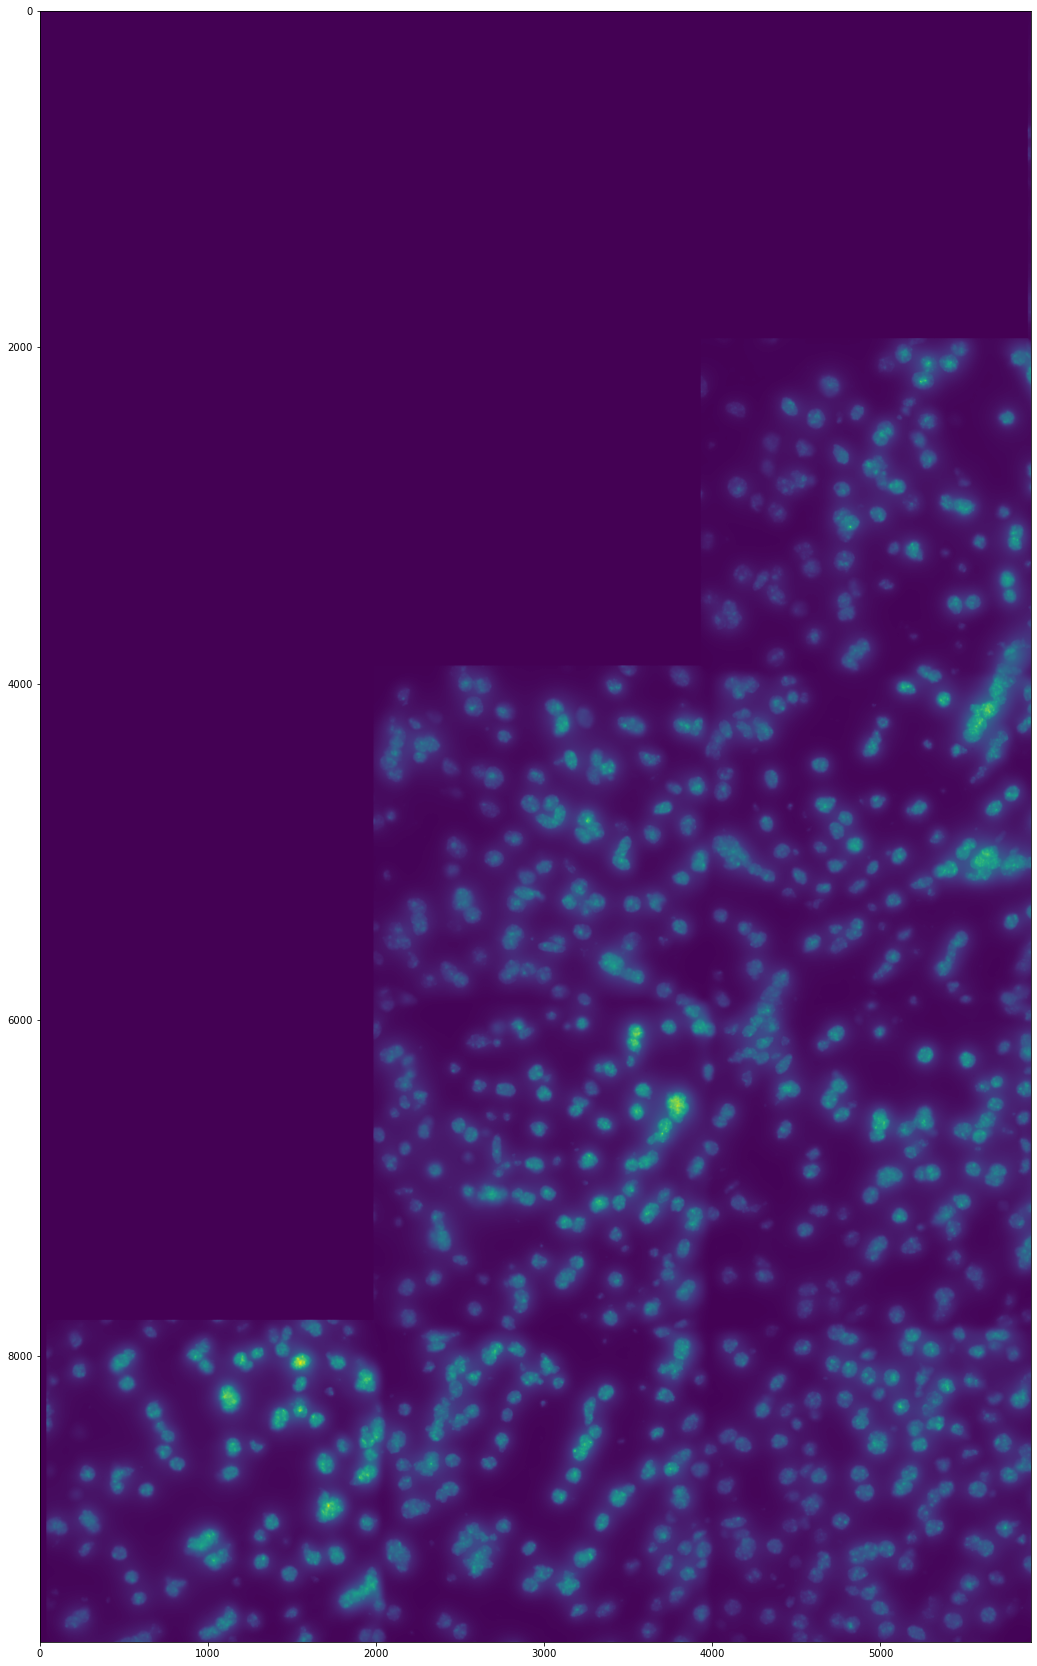

In [17]:
plt.figure(figsize=(30,30))
plt.imshow(canvas)

### Integration of Stardist

We call on the Stardist package to make predictions on the location and shapes of the nuclei within the image.

In [18]:
#importing stardist

from csbdeep.utils import Path, normalize

from stardist import random_label_cmap, _draw_polygons, export_imagej_rois
from stardist.models import StarDist2D

import time

model = StarDist2D.from_pretrained('2D_versatile_fluo')
lbl_cmap = random_label_cmap()

Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


In [19]:
#create new subfolder to store segmented images for faster access

if not os.path.exists('C:/Users/jv92c/Documents/mFISH/sample_data/DAPI_Overview_subimg_segmented'):
    os.makedirs('C:/Users/jv92c/Documents/mFISH/sample_data/DAPI_Overview_subimg_segmented')

In [20]:
#local machine
#source for raw images
img_path = 'C:/Users/jv92c/Documents/mFISH/sample_data/DAPI_Overview_subimg/'
img_list = os.listdir(img_path)
axis_norm = (0,1)

In [21]:
#destination folder for processed images
processed_dir = 'C:/Users/jv92c/Documents/mFISH/sample_data/DAPI_Overview_subimg_segmented'

In [22]:
overlay = np.zeros((boundary[-1][1], boundary[-1][3]))
overlay_pos = {}

In [23]:
#testing stardist on the sliced images
start = time.time()

for i, img in enumerate(img_list):
    
    subsample = imageio.imread(img_path+img_list[i])
    subsample = normalize(subsample, 1, 99.8, axis=axis_norm)
    labels, details = model.predict_instances(subsample)
        
    #plt.figure(figsize=(8,8))
    #plt.imshow(subsample if subsample.ndim==2 else subsample[...,0], clim=(0,1), cmap='gray')
    #plt.imshow(labels, cmap=lbl_cmap, alpha=0.5)
    #plt.axis('off')
    
    #saving subimages to disk
    imageio.imwrite('{}/DAPI_Overview_processed_subimage_{}.tif'.format(processed_dir, str(i).zfill(5)), labels)
    
    #creating a dictionary for the processed tiles
    #leveraging the img_coordinates array generated from the raw image slicer
    overlay_pos['DAPI_Overview_processed_subimage_'+str(i).zfill(5)] = [int(j) for j in img_coordinates[i]]

slicing_time = time.time() - start
print(slicing_time)

38.064326763153076


## Stitching Predictions

After writing the segmented files to disk, we read them here and reconstruct the image based on the tiles

In [24]:
processed_files = 'DAPI_Overview_processed_subimage_'

with open(filename, 'w') as file:    
    json.dump(overlay_pos, file)
    
with open(filename) as file:    
    overlay_pos = json.load(file, object_pairs_hook=OrderedDict)

In [25]:
for key in overlay_pos:
    
    '''
    within the zero ndarray, we overlay an image whose corners 
    will be set by the coordinates stored within the dictionary
    '''
    
    overlay[overlay_pos[key][0]:overlay_pos[key][1], overlay_pos[key][2]:overlay_pos[key][3]] = imageio.imread(processed_dir+'/'+'{}.tif'.format(str(key)))

overlay.shape

(9699, 5893)

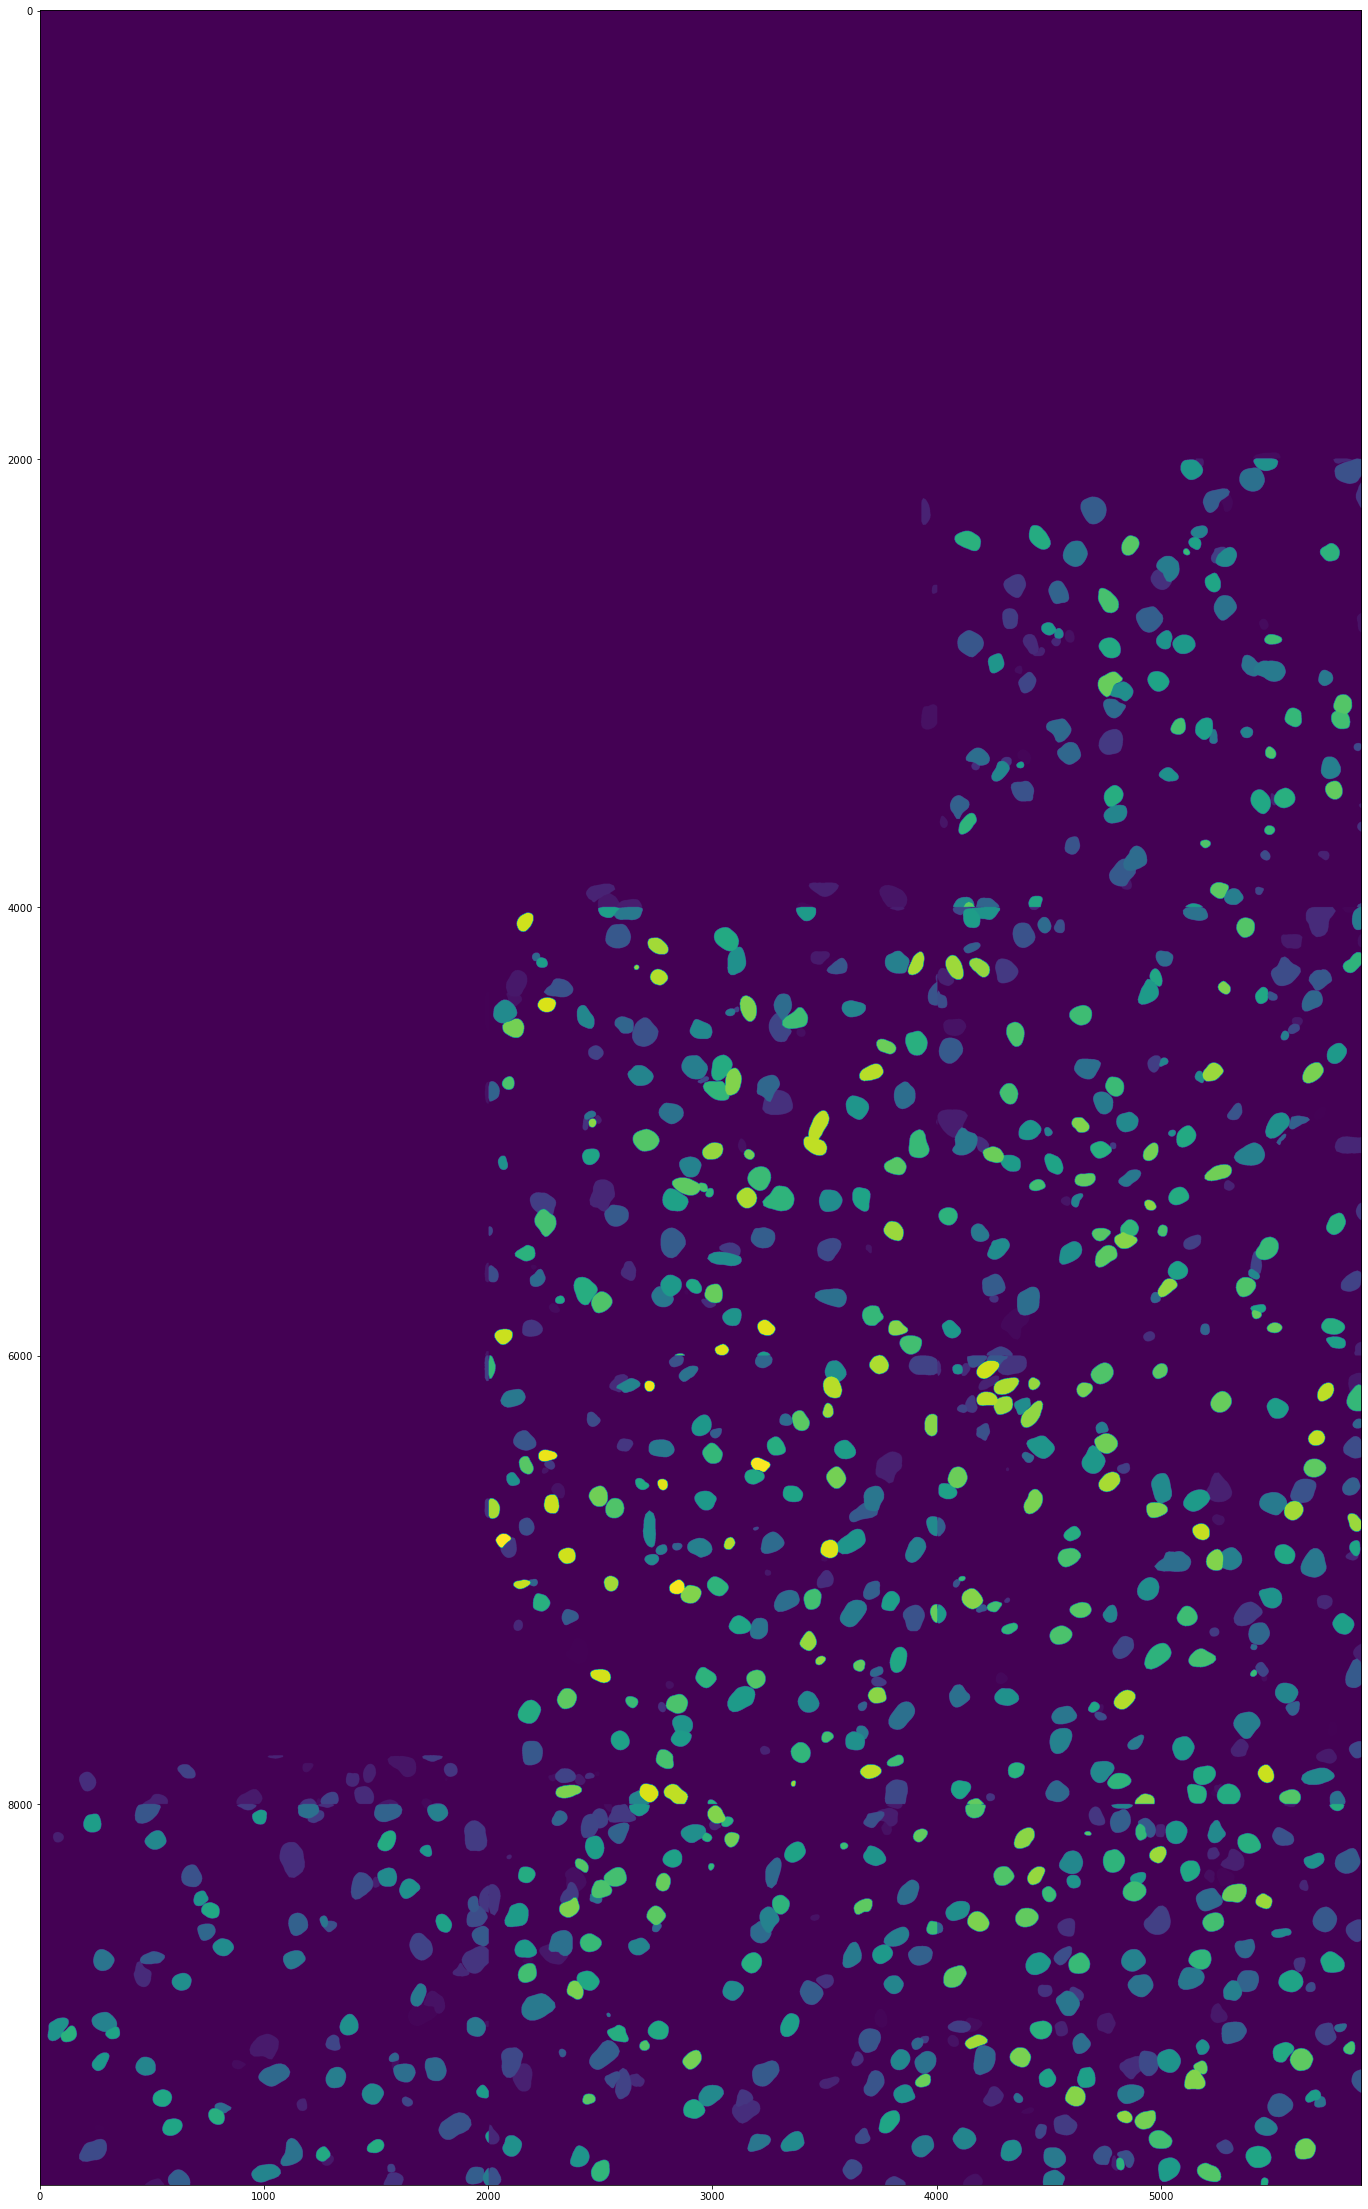

In [26]:
#overlaying labels onto the original

plt.figure(figsize=(40, 40))
#plt.imshow(canvas)
plt.imshow(overlay)

### Segmentation Errors

As one can observe, there are some obvious delineations between cells nested where two segmentation tiles overlap. This causes a mosaic of cells that exist in multiple areas simultaneously, and will affect accuracy of cell localization.

### Mitigating the issues of piecewise segmentation

To correct the stitching errors, we constructed the subimage tiles to overlap with one another, so that we can isolate the stitch areas, and find the common results between two segmentation instances. We must then refine our process when iterating through each tile, since we must now keep track of their adjacency.

Our approach is to compare the overlay to the incoming tile. If a nucleus exists in both, the difference in areas are calculated with an offset, to distinguish which portion of the nuclei is found in a particular tile. We then set smaller areas to zero, and retain the larger value. 

In [27]:
#creating new canvases

canvas = np.zeros((boundary[-1][1], boundary[-1][3]))
overlay = np.zeros((boundary[-1][1], boundary[-1][3]))

In [ ]:
#reduced loop for testing overlap isolation

start = time.time()
overlap_cells = []

for i, key in enumerate(overlay_pos):
    
    #fetching segmented image tiles
    current_file = str(processed_dir+'/'+'{}.tif'.format(str(key)))
    label_img = imageio.imread(processed_dir+'/'+'{}.tif'.format(str(key)))
    
    #introducing an offset to uniquely identify individual tiles
    tile_offset = 1000*i
    label_img = label_img + tile_offset
    label_img[label_img == tile_offset] = 0
    
    current_subsample = overlay[overlay_pos[key][0]:overlay_pos[key][1], overlay_pos[key][2]:overlay_pos[key][3]]
    print('---------------------------------------')
    print('checking current subsample')
    
    for ii in np.unique(label_img):
        
        if ii == 0:
            print('cells not detected')
            continue
        
        unique_cells = np.unique(current_subsample[label_img==ii])
        unique_cells = unique_cells[unique_cells > 0]
                
        size_in_tile = np.count_nonzero(label_img == ii)
        #print(size_in_tile, ii)
        
        size_in_overlay = np.count_nonzero(overlay == ii)
        
        for cell in unique_cells:
        
            if unique_cells.shape[0] > 0:
                size_in_overlay = np.count_nonzero(overlay == cell)        
                #print(size_in_overlay, cell)
            else:
                size_in_overlay = 0

            if size_in_tile > size_in_overlay:
                #print('larger in tile')        
                current_subsample[label_img == ii] = 0

            elif size_in_tile == size_in_overlay:
                #print('same size')

            elif size_in_overlay > size_in_tile:
                #print('overlap is bigger')
                label_img[current_subsample == ii] = 0
        
        #print(unique_cells)
        #print('---------')    
        overlap_cells.append([key, ii, 'label_img_cell = '+str(size_in_tile), 'overlay_cell = '+str(size_in_overlay)])
            
    overlay[overlay_pos[key][0]:overlay_pos[key][1], overlay_pos[key][2]:overlay_pos[key][3]] = label_img + current_subsample
    
    #recording number of detected objects
    #cells_detected = cells_detected + int(len(details['coord']))
    #mean_cell_per_slice = cells_detected / int(len(img_list))

    #constructing stiched predictions from binary label masks
    #current_subsample = np.logical_or(current_subsample, labels > 0)

process_time = time.time() - start
print(process_time)

## Comparison between overlaps

Here we append the results of our overlap check into a list, to see whether or not we can isolate nuclei that exist in multiple image segmentations. Though successful, there is still much more left to be desired. Note how in almost all cases, the difference in size is either same, or the incoming tile is bigger. This hints that we are not able to make a full comparison between two different instances of the same cell. The segment in the overlap is only the portion that exists in the overlap between two or more tiles, and therefore leads to an inaccurate area size.

In [ ]:
overlap_cells

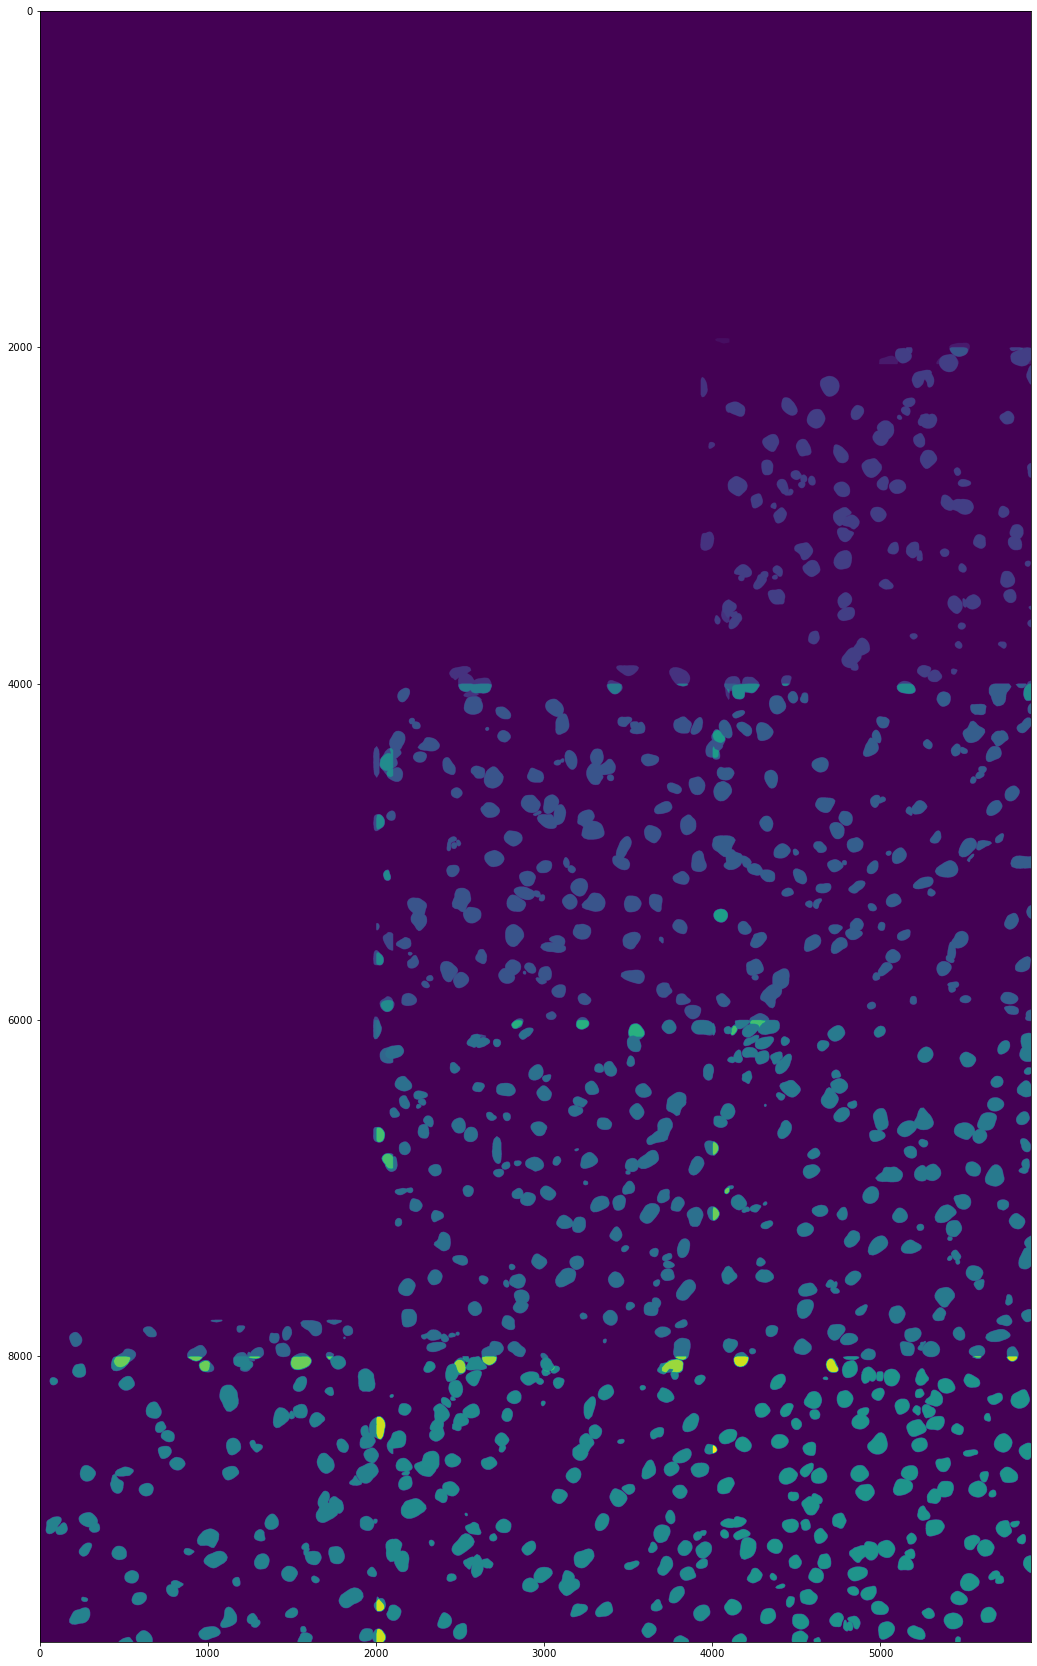

In [32]:
plt.figure(figsize=(30,30))
plt.imshow(overlay)

## Stardist Tile-Wise Segmentation

Fortunately, stardist itself comes with an implementation of the tile-based approach that we have attempted thus far. As one can see, the identification of overlapping cells is much more satisfactory, and instances where very small slivers of nuclei appearing in boundaries between two tiles is also minimized.

Even more fortunately, thanks to the foresight of the Stardist team, there is also a purpose-built predictor model that takes in large images as inputs.

The results of testing both are as follows:

---

In [38]:
sample = normalize(sample, 1, 99.8, axis=axis_norm)
labels, details = model.predict_instances(sample, n_tiles=(5,3), show_tile_progress=True)

  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:26<00:00,  1.77s/it]


(-0.5, 5892.5, 9698.5, -0.5)

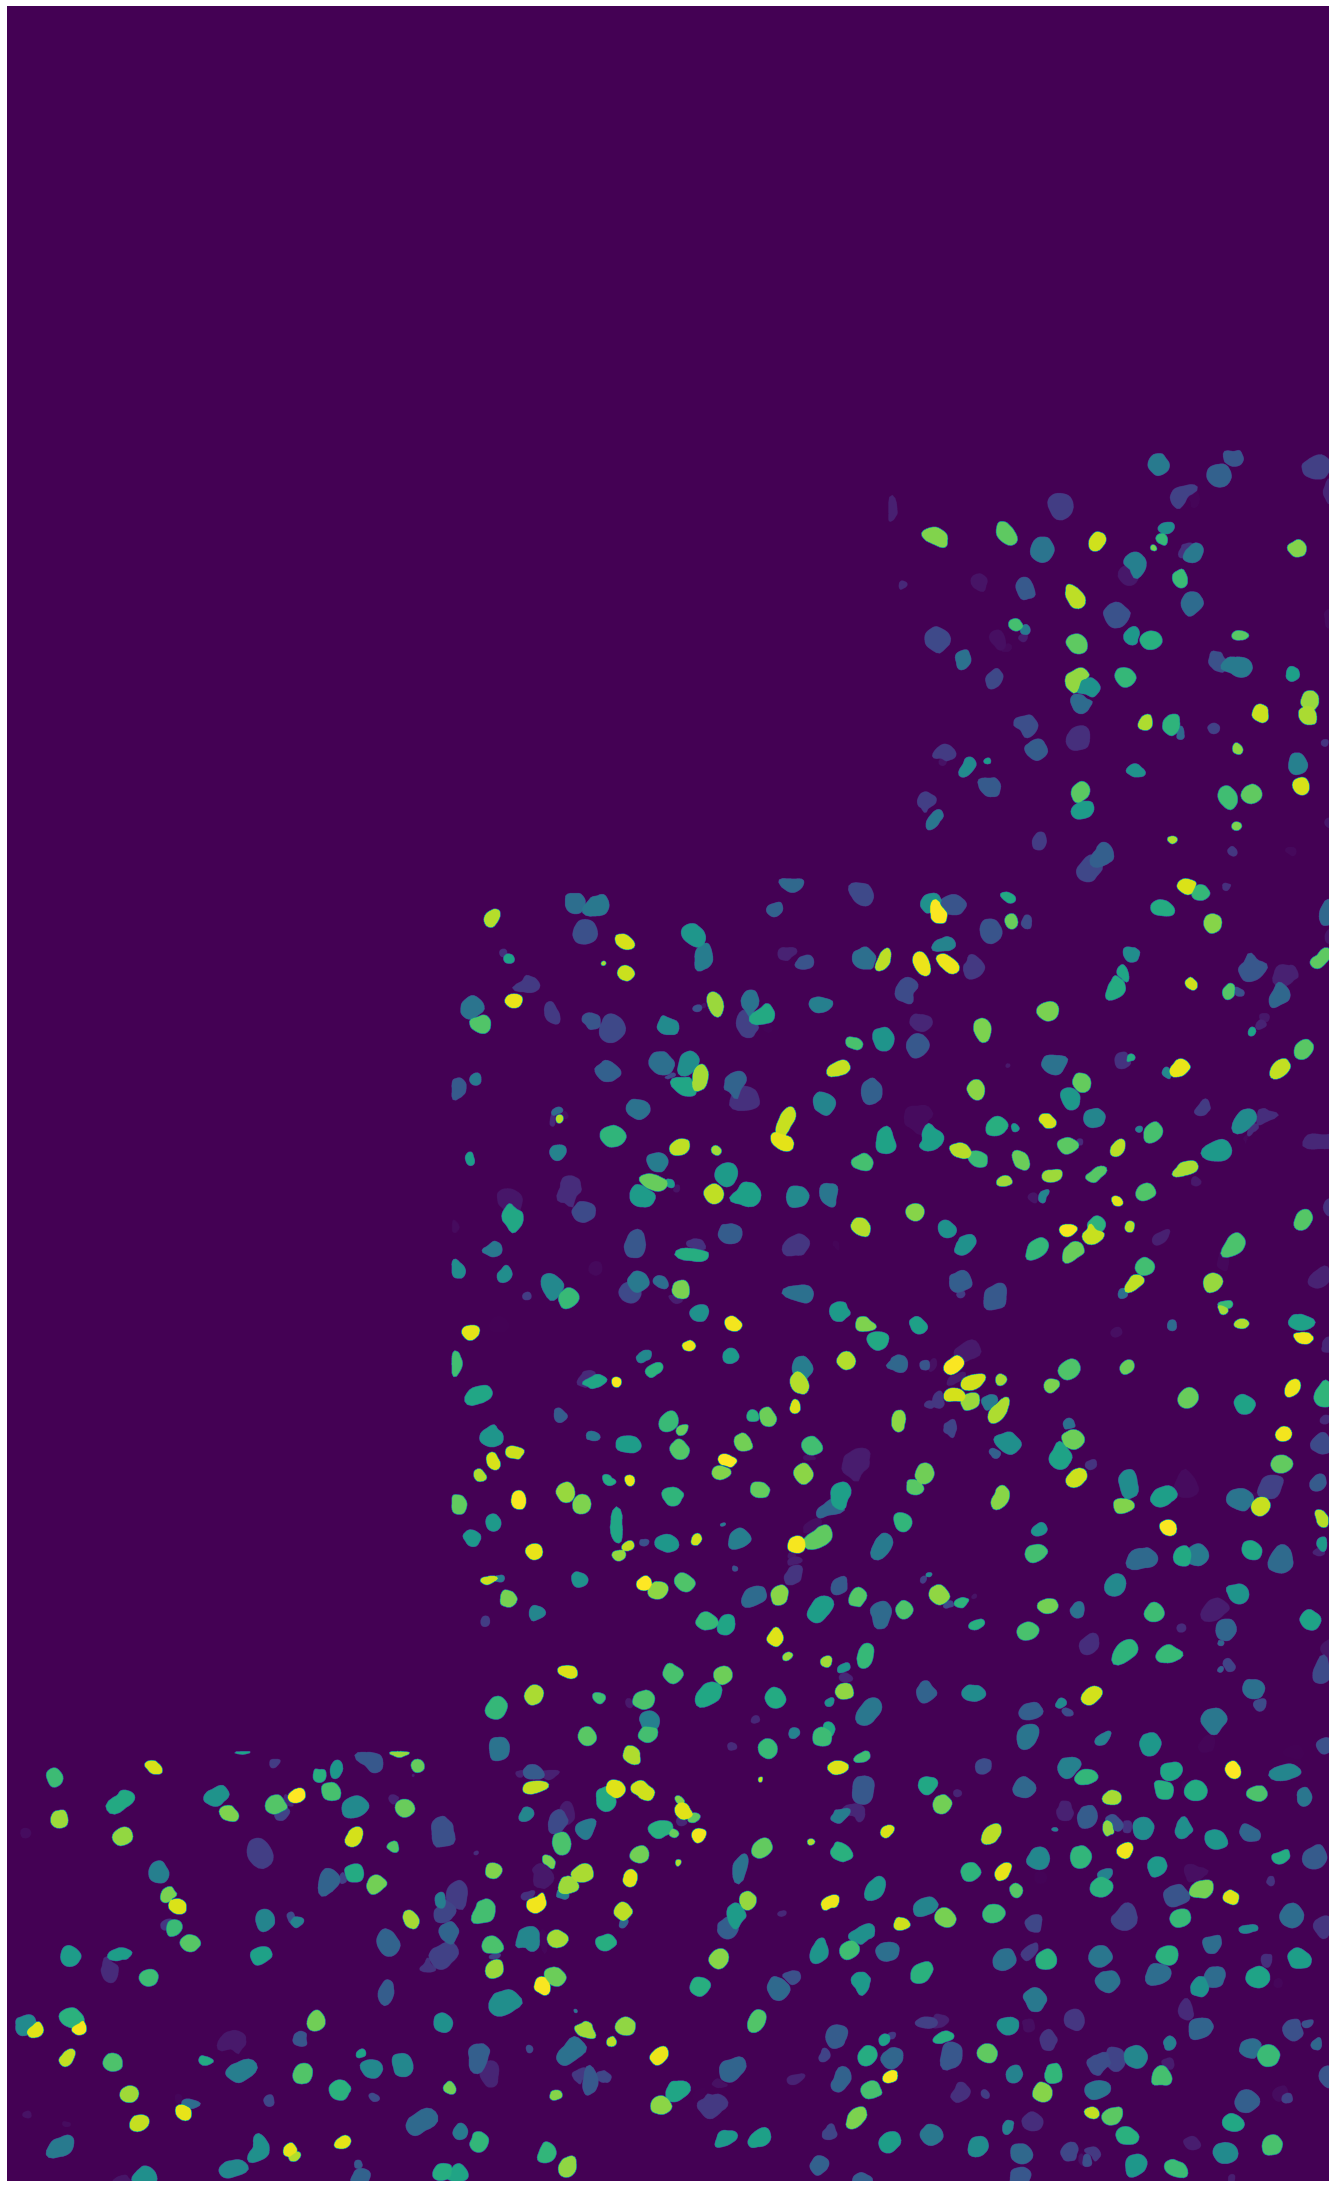

In [41]:
plt.figure(figsize=(40,40))
#plt.imshow(sample if sample.ndim==2 else sample[...,0], clim=(0,1), cmap='gray')
plt.imshow(labels)
plt.axis('off')

In [42]:
large_sample = img_as_float(io.imread('C:/Users/jv92c/Documents/mFISH/sample_data/DAPI_Overview.tif'))

In [44]:
large_sample = normalize(large_sample, 1, 99.8, axis=axis_norm)
biglabels, bigdetails = model.predict_instances_big(large_sample, axes='YX', block_size=4096, min_overlap=128, show_tile_progress=True)

effective: block_size=(4096, 4096), min_overlap=(128, 128), context=(96, 96)
changing 'show_tile_progress' from True to False


100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [06:27<00:00, 10.76s/it]


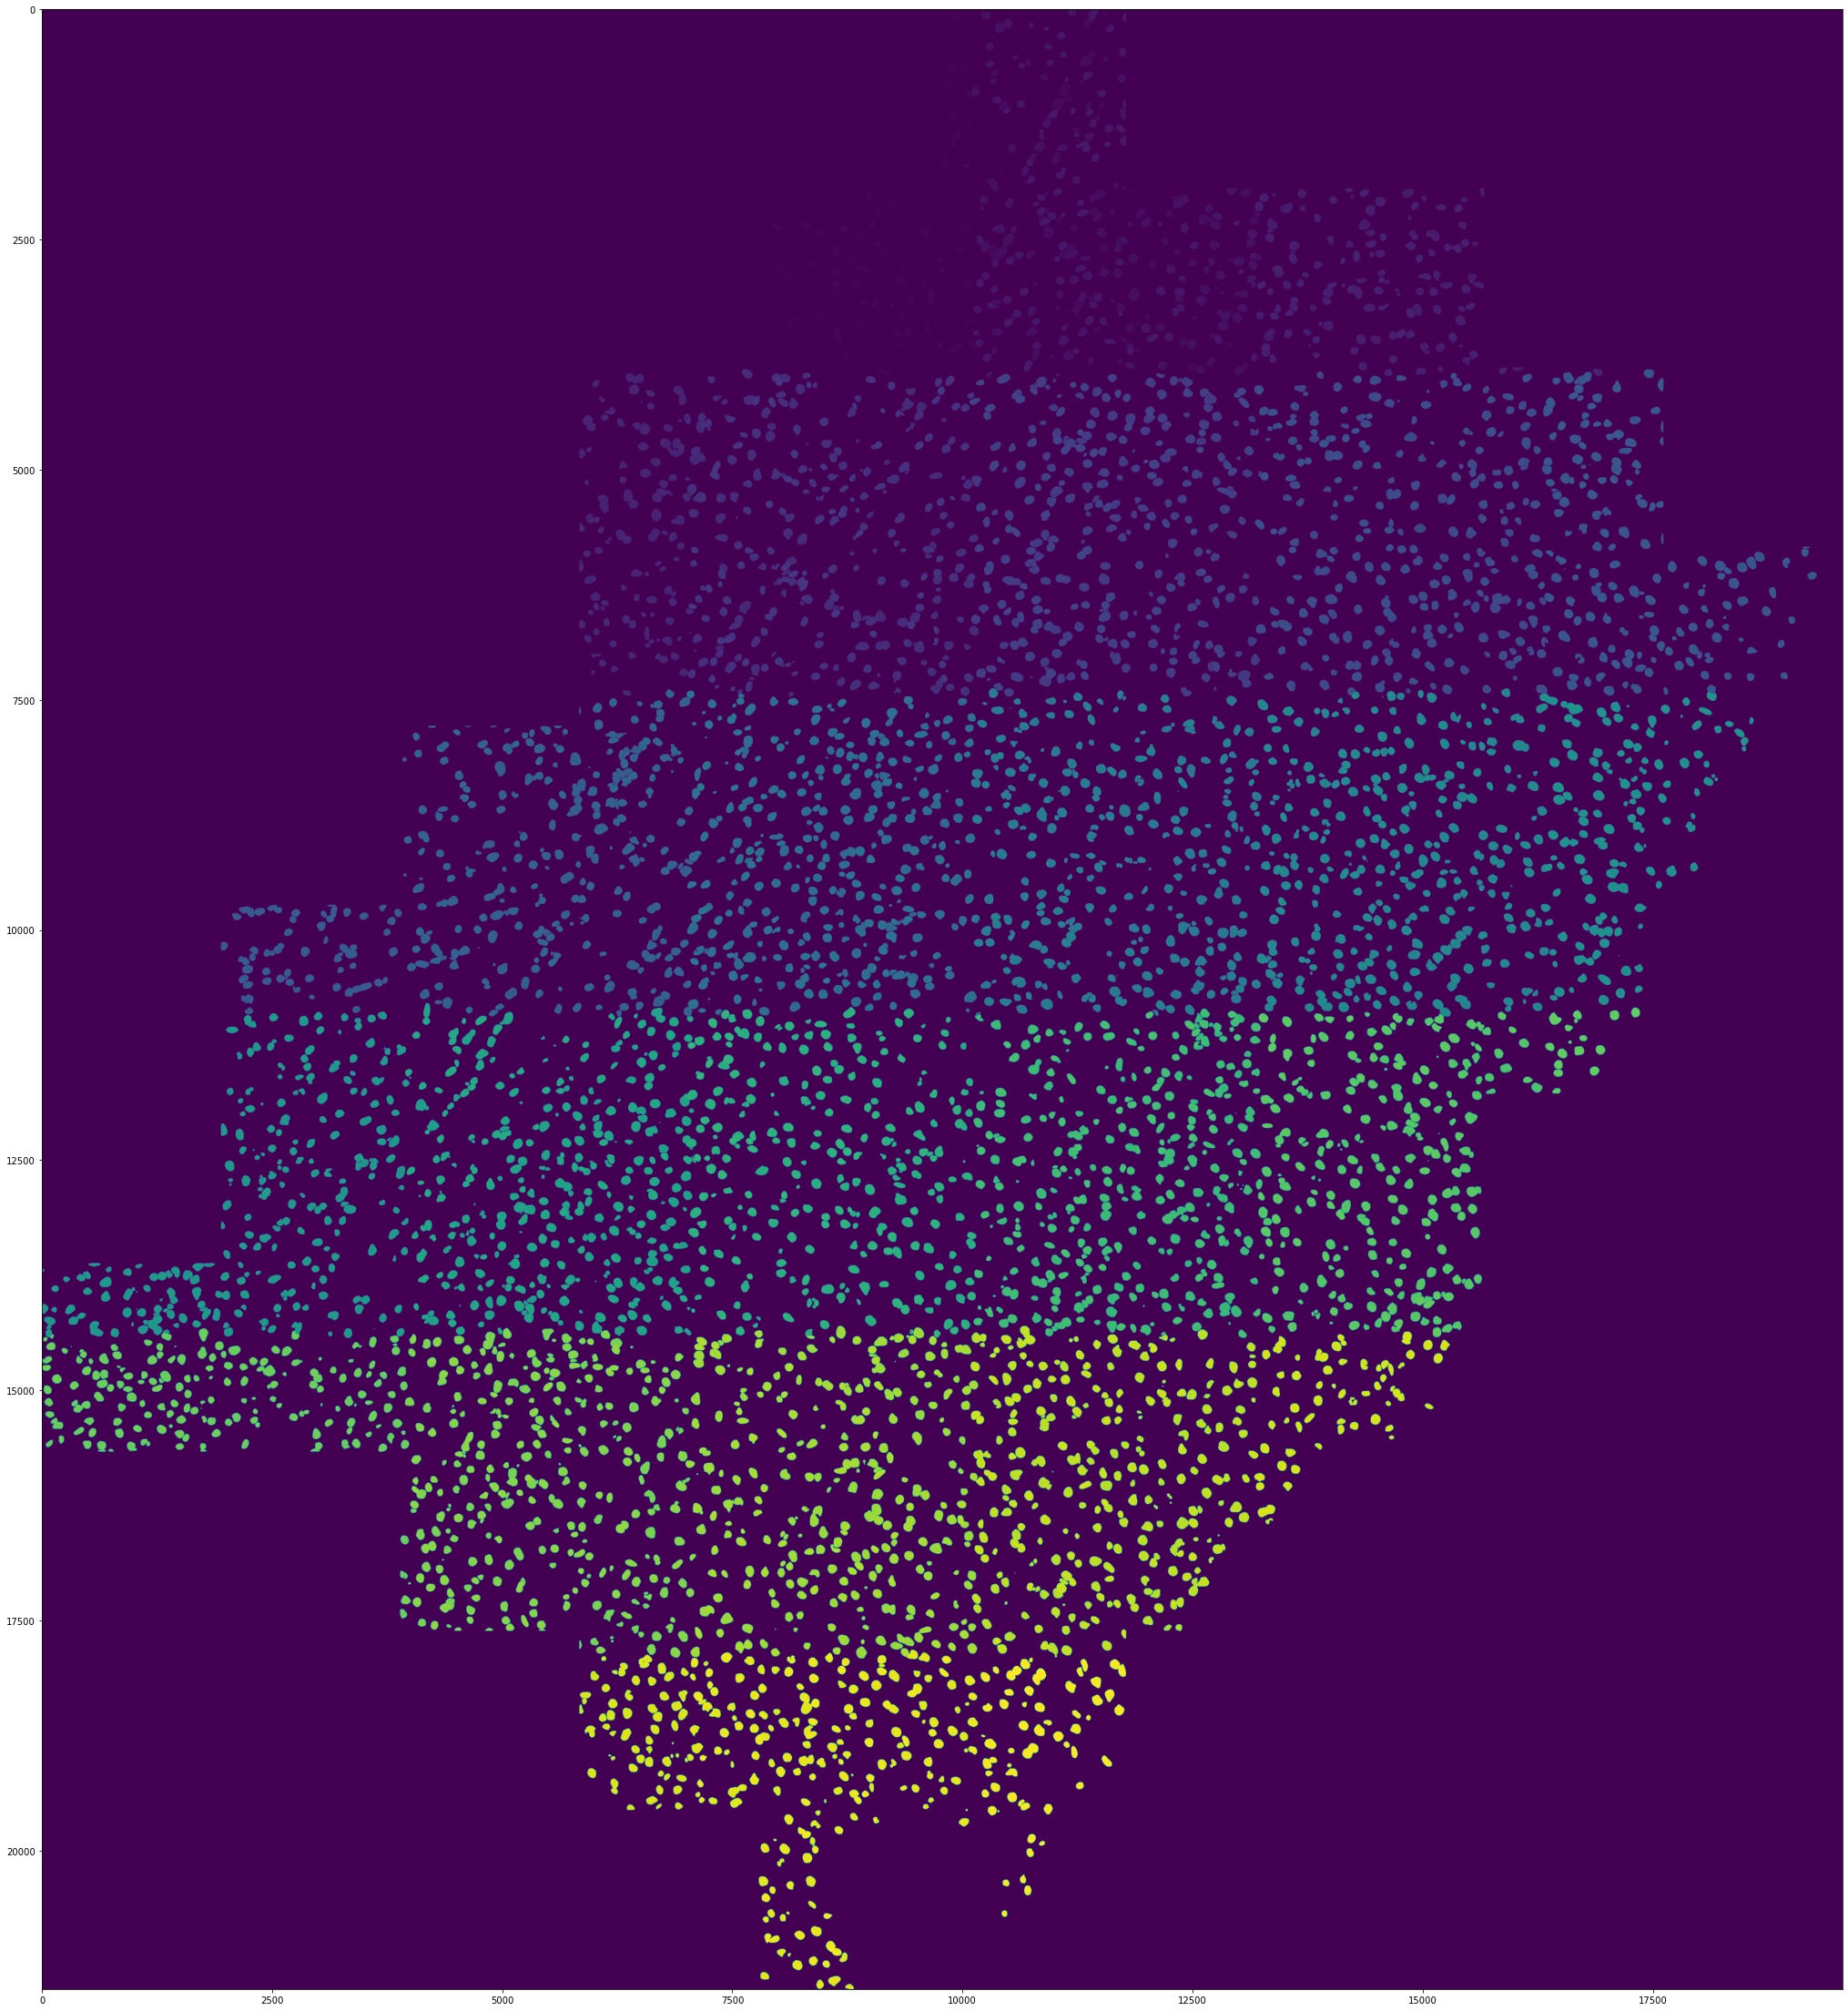

In [45]:
plt.figure(figsize=(40,40))
plt.imshow(biglabels)

### Conclusion

The purpose of this image slicer module is to make possible the processing of large images by dividing them into smaller subimages and pushing each through the Stardist segmentation model. Typically, a 20000 X 20000 image would exact a large toll on computational resources, even on purpose-built machines. By applying this module, we hope to reduce cost and allow even personal machines with mid-range specs to get the job done.

However, this is not without its faults. As the image is evaluated by the model piecewise, there is an inherent risk of error with objects that are bifurcated along subimage tile edges. This causes inconsistencies with the shape of detected nuclei, and can affect total number of objects detected. A possible fix is to use binary images and by taking advantage of the built-in offsets within the grid to try and stitch together objects along gridlines.

Thankfully, much of the heavy-lifting is eliminated, thanks to the built-in functions of the Stardist predictor. Though runtimes as displayed in the above executions are long, these results are actually good, considering that the notebook was run on a commercial laptop, and exclusively on CPU. Running this same method on purpose-built machines with high-performance GPUs are guaranteed to drastically shorten runtimes, ensuring a seamless integration into the mFISH processing pipeline, in the forseeable future. Thank you. 


#### Full disclosure on specs for local machine:
 - Intel Core i7-10875H CPU @ 2.30GHz, 8-core
 - 16GB RAM
 - NVIDIA RTX 2060 Max-Q